In [111]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import json
import requests
import pandas as pd

In [112]:
QUERY_NUMBER = "q5"
QUERY_PATH = '../queries/' + QUERY_NUMBER + '/' + QUERY_NUMBER

BASE_QUERY_URL = "http://localhost:8983/solr/games/select?fl=*%2C%5Bchild%5D&fq=%7B!child%20of%3D%22*%3A*%20-_nest_path_%3A*%22%7Dsummary%3A(unique%20OR%20characters%20OR%20%22unique%20story%22)%20OR%20wikipedia%3A(unique%20OR%20characters%20OR%20%22unique%20story%22)&indent=true&q.op=OR&q=review%3A(unique%20OR%20characters%20OR%20%22unique%20story%22)&rows=1000&useParams=&wt=json"
BOOSTED_QUERY_URL = "http://localhost:8983/solr/games/select?bq=%7B!child%20of%3D%22*%3A*%20-_nest_path_%3A*%22%7Dsummary%3A(unique%20OR%20characters%20OR%20%22unique%20story%22)%20OR%20wikipedia%3A(unique%20OR%20characters%20OR%20%22unique%20story%22)&defType=edismax&fq=%7B!child%20of%3D%22*%3A*%20-_nest_path_%3A*%22%7Dtitle%3A*&indent=true&pf=review%5E2&ps=3&q.op=AND&q=unique%20OR%20characters%20OR%20%22unique%20story%22&qf=review%5E2&rows=1000&useParams=&wt=json"

#### Executa a base query e guarda os documentos obtidos no ficheiro baseRank.txt

In [113]:
#Query retorna reviews
base_results_reviews = requests.get(BASE_QUERY_URL).json()['response']['docs']
base_gameids = []
base_results = []

for index, doc in enumerate(base_results_reviews):
    if len(base_gameids) == 10:
        break
    
    if doc['id'].split('/')[0] not in base_gameids:
        #print("\nGetting game with id: ", doc['id'].split('/')[0])
        base_gameids.append(doc['id'].split('/')[0])
        query_url = "http://localhost:8983/solr/games/select?fl=*%2C%5Bchild%5D&indent=true&q.op=OR&q=id%3A(" + doc['id'].split('/')[0] + ')&useParams=&wt=json'
        result = requests.get(query_url).json()['response']['docs']
        #print(result)
        base_results.append(result[0])

base_ranked_doc = [doc['title'] for index, doc in enumerate(base_results)]

df_base = pd.DataFrame(base_ranked_doc, columns=['BASE'], index=None)

print(df_base)

latex_table = df_base.to_latex(index=False)

with open(QUERY_PATH+'_baseRank.txt', 'w') as tf:
    tf.write(latex_table)


                                    BASE
0                           Mad Rat Dead
1                 The Punisher: No Mercy
2                        The Incredibles
3                           Rocket Arena
4                   Disney Magical World
5                    XCOM: Chimera Squad
6                         Chrono Trigger
7               Final Fantasy VI Advance
8  Tales of Vesperia: Definitive Edition
9          Ori and the Will of the Wisps


In [114]:
#Query retorna reviews
boosted_results_reviews = requests.get(BOOSTED_QUERY_URL).json()['response']['docs']
boosted_gameids = []
boosted_results = []

for index, doc in enumerate(boosted_results_reviews):
    if len(boosted_gameids) == 10:
        break
    
    if doc['id'].split('/')[0] not in boosted_gameids:
        #print("\nGetting game with id: ", doc['id'].split('/')[0])
        boosted_gameids.append(doc['id'].split('/')[0])
        query_url = "http://localhost:8983/solr/games/select?fl=*%2C%5Bchild%5D&indent=true&q.op=OR&q=id%3A(" + doc['id'].split('/')[0] + ')&useParams=&wt=json'
        result = requests.get(query_url).json()['response']['docs']
        #print(result)
        boosted_results.append(result[0])

boosted_ranked_doc = [doc['title'] for index, doc in enumerate(boosted_results)]

df_boosted = pd.DataFrame(boosted_ranked_doc, columns=['BOOSTED'], index=None)

print(df_boosted)

latex_table = df_boosted.to_latex(index=False)

with open(QUERY_PATH+'_boostedRank.txt', 'w') as tf:
    tf.write(latex_table)

                                      BOOSTED
0                        Disney Magical World
1                         XCOM: Chimera Squad
2                                Rocket Arena
3  Conception II: Children of the Seven Stars
4                  Torment: Tides of Numenera
5               Ori and the Will of the Wisps
6                                Mad Rat Dead
7                      The Punisher: No Mercy
8              Chicken Police - Paint it RED!
9                             The Incredibles


#### Depois construir o ficheiro com todos os documentos relevantes

In [115]:
relevant = list(map(lambda el: el.strip(), open(QUERY_PATH+'_relevant.txt').readlines()))

print(relevant)

['Disney Magical World', 'Mad Rat Dead', 'XCOM: Chimera Squad', 'Chrono Trigger', 'Final Fantasy VI Advance', 'Ori and the Will of the Wisps']


#### Definição das métricas

In [116]:
metrics = {}
metric = lambda f: metrics.setdefault(f.__name__, f)

@metric
def p10(results, relevant, n=10):
    """Precision at N"""
    return len([doc for doc in results[:n] if doc['title'] in relevant])/n

@metric
def ap(results, relevant):
    """Average Precision"""
    precision_values = []
    relevant_count = 0

    for idx, doc in enumerate(results):
        if doc['title'] in relevant:
            relevant_count += 1
            precision_at_k = relevant_count / (idx + 1)
            precision_values.append(precision_at_k)

    if not precision_values:
        return 0.0

    return sum(precision_values)/len(precision_values)

def calculate_metric(key, results, relevant):
    return metrics[key](results, relevant)

evaluation_metrics = {
    'ap': 'Average Precision',
    'p10': 'Precision at 10 (P@10)'
}

# Calcular e imprimir as métricas
for metric_key, metric_name in evaluation_metrics.items():
    metric_value_base = calculate_metric(metric_key, base_results, relevant)
    metric_value_boosted = calculate_metric(metric_key, boosted_results, relevant)
    print(f'{metric_name}: {metric_value_base}   {metric_value_boosted}')
    
# Calcular métricas
metrics_results_base = [calculate_metric(metric_key, base_results, relevant) for metric_key in evaluation_metrics.keys()]
metrics_results_boosted = [calculate_metric(metric_key, boosted_results, relevant) for metric_key in evaluation_metrics.keys()]

# Criar DataFrame do Pandas para os resultados das métricas
metrics_df = pd.DataFrame(list(zip(evaluation_metrics.values(), metrics_results_base, metrics_results_boosted)), columns=['Metrics', 'Base System', 'Boosted System'])

# Converter o DataFrame para uma tabela LaTeX sem um índice
latex_table_metrics = metrics_df.to_latex(index=False)

# Escrever a tabela LaTeX em um arquivo
with open(QUERY_PATH + "_metrics.tex", 'w') as tf:
    tf.write(latex_table_metrics)

Average Precision: 0.6160714285714286   0.7678571428571428
Precision at 10 (P@10): 0.6   0.4


#### Função que cálcula a curva de Precision-Recall

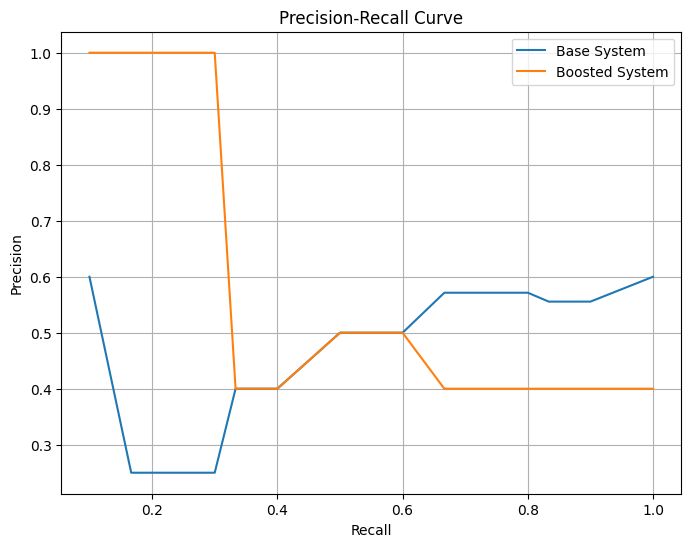

In [117]:
def evaluate(results):
    precision_values = [
        len([
            doc 
            for doc in results[:idx]
            if doc['title'] in relevant
        ]) / idx 
        for idx, _ in enumerate(results, start=1)
    ]
    
    recall_values = [
        len([
            doc for doc in results[:idx]
            if doc['title'] in relevant
        ]) / len(relevant)
        for idx, _ in enumerate(results, start=1)
    ]
    
    precision_recall_match = {k: v for k,v in zip(recall_values, precision_values)}
    
    # Extend recall_values to include traditional steps for a better curve (0.1, 0.2 ...)
    recall_values.extend([step for step in np.arange(0.1, 1.1, 0.1) if step not in recall_values])
    recall_values = sorted(set(recall_values))

    # Extend matching dict to include these new intermediate steps
    for idx, step in enumerate(recall_values):
        if step not in precision_recall_match:
            if recall_values[idx-1] in precision_recall_match:
                precision_recall_match[step] = precision_recall_match[recall_values[idx-1]]
            else:
                precision_recall_match[step] = precision_recall_match[recall_values[idx+1]]
                
    return precision_recall_match, recall_values

pr_match_base, recall_values_base = evaluate(base_results)
pr_match_boosted, recall_values_boosted = evaluate(boosted_results)

# Plotar um único gráfico para ambos os sistemas
plt.figure(figsize=(8, 6))
plt.plot(recall_values_base, [pr_match_base.get(r) for r in recall_values_base], label='Base System')
plt.plot(recall_values_boosted, [pr_match_boosted.get(r) for r in recall_values_boosted], label='Boosted System')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.savefig(QUERY_PATH + '_combined_pr.pdf')
plt.show()
    

In [118]:
base_document_ids = [doc['title'] for doc in base_results]
base_relevance_column = ['Y' if doc_id in relevant else 'N' for doc_id in base_document_ids]

boosted_document_ids = [doc['title'] for doc in boosted_results]
boosted_relevance_column = ['Y' if doc_id in relevant else 'N' for doc_id in boosted_document_ids]

ranked_documents = list(zip(range(1, len(base_results) + 1), base_document_ids, base_relevance_column, boosted_document_ids, boosted_relevance_column))

df1 = pd.DataFrame(ranked_documents, columns=['Rank', 'Base System', 'Relevance', 'Boosted System', 'Relevance'])

# Convert the DataFrame to a LaTeX table without an index
latex_table = df1.to_latex(index=False)

# Write the LaTeX table to a file
with open(QUERY_PATH+'_ranked_documents.tex', 'w') as tf:
    tf.write(latex_table)

# Print the LaTeX table
print(latex_table)

\begin{tabular}{rllll}
\toprule
Rank & Base System & Relevance & Boosted System & Relevance \\
\midrule
1 & Mad Rat Dead & Y & Disney Magical World & Y \\
2 & The Punisher: No Mercy & N & XCOM: Chimera Squad & Y \\
3 & The Incredibles & N & Rocket Arena & N \\
4 & Rocket Arena & N & Conception II: Children of the Seven Stars & N \\
5 & Disney Magical World & Y & Torment: Tides of Numenera & N \\
6 & XCOM: Chimera Squad & Y & Ori and the Will of the Wisps & Y \\
7 & Chrono Trigger & Y & Mad Rat Dead & Y \\
8 & Final Fantasy VI Advance & Y & The Punisher: No Mercy & N \\
9 & Tales of Vesperia: Definitive Edition & N & Chicken Police - Paint it RED! & N \\
10 & Ori and the Will of the Wisps & Y & The Incredibles & N \\
\bottomrule
\end{tabular}

